# Create region mask and timeseries for freshwater IAF simulation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shutil as shutil

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/freshwater_IAF/forcing/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34983/status,
Dashboard: /proxy/34983/status,Workers: 7
Total threads: 28,Total memory: 125.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38029,Workers: 7
Dashboard: /proxy/34983/status,Total threads: 28
Started: Just now,Total memory: 125.21 GiB
Comm: tcp://127.0.0.1:40271,Total threads: 4
Dashboard: /proxy/37261/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:45937,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

lat_slice  = slice(-90,-59)

In [4]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=13

## Create region masks

In [5]:
# open FW forcing, so have correct JRA grid:
#runoff_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.runoff_all.1990_1991.nc'

# note melt and calving are input separately. Need to add both contributions to get total:
runoff_file1 = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/landIce/day/licalvf/gr/v20190429/licalvf_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_19580101-19581231.nc'
ds = xr.open_dataset(runoff_file1,decode_times=False)
# extract arrays from dataset:
runoff1 = ds.licalvf
runoff1 = runoff1.isel(time=0).drop('time').sel(lat=lat_slice)

runoff_file2 = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/land/day/friver/gr/v20190429/friver_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_19580101-19581231.nc'
ds = xr.open_dataset(runoff_file2,decode_times=False)
# extract arrays from dataset:
runoff2 = ds.friver
runoff2 = runoff2.isel(time=0).drop('time').sel(lat=lat_slice)

runoff = runoff1 + runoff2
#plt.figure(figsize=(12,8))
#runoff.plot(vmin=0,vmax=1e-4,cmap=cmocean.amp)

# create region masks:
# David to Denman:
Wilkes_mask = runoff*0 + 1
Wilkes_mask = Wilkes_mask.where((runoff.lat>-76)&(runoff.lon>95)&(runoff.lon<180))

# Fox to Nickerson:
AB_mask = runoff*0 + 1
AB_mask = AB_mask.where((runoff.lon<360-80)&(runoff.lon>=360-146))

#Larsen C to Stange:
Peninsula_mask = runoff*0 + 1
Peninsula_mask = Peninsula_mask.where((runoff.lon<360-40)&(runoff.lon>=360-80))
Peninsula_mask = Peninsula_mask.where(~((runoff.lon>295)&(runoff.lat<-70)))

combined_mask = Wilkes_mask.fillna(0) + AB_mask.fillna(0)*2 + Peninsula_mask.fillna(0)*3
combined_mask = combined_mask.where(combined_mask>0)

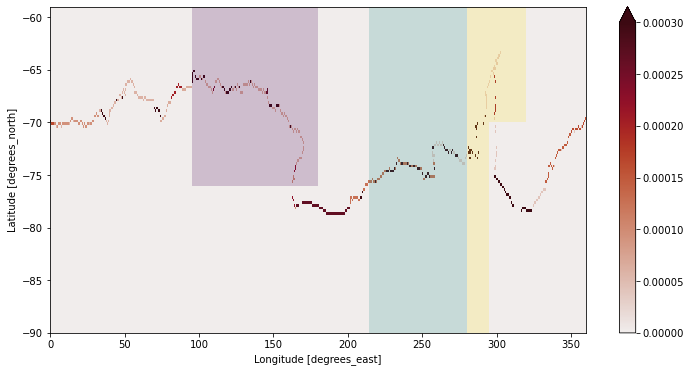

In [6]:
plt.figure(figsize=(12,6))
runoff.plot(cmap=cmocean.amp,vmax=3e-4)
plt.pcolormesh(combined_mask.lon,combined_mask.lat,combined_mask,alpha=0.2)
#plt.ylim(-80,-70)
#plt.xlim(100,200)

## Check control runoff in each region:

In [6]:
# need area on the JRA grid:
# data is 0.25 deg.
resolution=0.25
radius = 6376e3
dy = radius*(np.pi/180*resolution) + runoff.lat*0
dx = dy*np.cos(runoff.lat/180*np.pi)
area = dy*dx

# conversion to Gt/yr:
conversion_factor = 60*60*24*365.25/1e12
# to convert to Sv:
#conversion_factor = (1e-3)*(1e-6)

# check whole Antarctic runoff, should be close to 2775 Gt/y (Depoorter). Also it matches 0.0876 Sv stated in Tsujino et al. 2018:
Antarctica_runoff = (runoff*area).sum('lon').sum('lat')*conversion_factor
# Antarctica_runoff = 2764 Gt/y

Wilkes_runoff = (runoff*Wilkes_mask*area).sum('lon').sum('lat')*conversion_factor
# Wilkes_runoff = 587.3 Gt/y

AB_runoff = (runoff*AB_mask*area).sum('lon').sum('lat')*conversion_factor
# AB_runoff = 812.2 Gt/y

Peninsula_runoff = (runoff*Peninsula_mask*area).sum('lon').sum('lat')*conversion_factor
# Peninsula_runoff = 243.6 Gt/y

## Rignot obs numbers:

In [7]:
# Rignot grounding line flux anomalies, in Gt/y:
# Note these are taken from dD in Table 2.
rignot_West_Antarctica = np.array((9.9,23.7,70.6,131.9))
rignot_Peninsula = np.array((7.6,12.1,31.3,45.1))

# Note for Wilkes Land – these estimates are the sum for the whole of East Antarctica, 
# but they come out similar if you just add the Wilkes Land regions, so use whole of East Antarctic numbers, 
# but apply just in Wilkes Land.
rignot_East_Antarctica = np.array((34.5,43.3,28.2,36.7))

## Compute percent anomalies each decade:

In [9]:
Peninsula_percent = rignot_Peninsula/Peninsula_runoff.values
West_Antarctica_percent = rignot_West_Antarctica/AB_runoff.values
East_Antarctica_percent = rignot_East_Antarctica/Wilkes_runoff.values

In [10]:
# get time dimension:
runoff_file1 = '/g/data/v45/pas561/jnb/force_melt/friver_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_19790101-20190105.cat.nc'
ds = xr.open_dataset(runoff_file1,decode_times=False)
# extract arrays from dataset:
runoff1 = ds.friver
# this is way too slow:
#runoff1 = runoff1.load()

In [25]:
year = [1984,1994,2004,2014]
whole_time = np.arange(1979.,2019.)
whole_time = xr.DataArray(whole_time, coords = [('year', whole_time)])
from numpy.polynomial import Polynomial

# first construct time series that have rignot values at annual frequency (not just central point in decades):
West_Antarctica_percent_timeseries = whole_time.copy()
West_Antarctica_percent_timeseries[:10] = West_Antarctica_percent[0]
West_Antarctica_percent_timeseries[10:20] = West_Antarctica_percent[1]
West_Antarctica_percent_timeseries[20:30] = West_Antarctica_percent[2]
West_Antarctica_percent_timeseries[30:40] = West_Antarctica_percent[3]
# rignot finishes a 2017, so cut off last 2 years:
West_Antarctica_percent_timeseries = West_Antarctica_percent_timeseries[:-2]

East_Antarctica_percent_timeseries = whole_time.copy()
East_Antarctica_percent_timeseries[:10] = East_Antarctica_percent[0]
East_Antarctica_percent_timeseries[10:20] = East_Antarctica_percent[1]
East_Antarctica_percent_timeseries[20:30] = East_Antarctica_percent[2]
East_Antarctica_percent_timeseries[30:40] = East_Antarctica_percent[3]
East_Antarctica_percent_timeseries = East_Antarctica_percent_timeseries[:-2]

Peninsula_percent_timeseries = whole_time.copy()
Peninsula_percent_timeseries[:10] = Peninsula_percent[0]
Peninsula_percent_timeseries[10:20] = Peninsula_percent[1]
Peninsula_percent_timeseries[20:30] = Peninsula_percent[2]
Peninsula_percent_timeseries[30:40] = Peninsula_percent[3]
Peninsula_percent_timeseries = Peninsula_percent_timeseries[:-2]


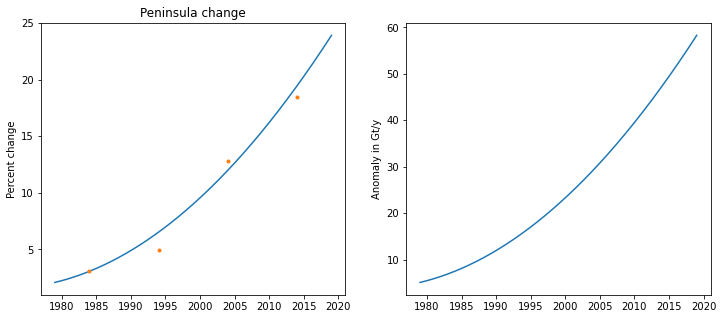

In [30]:
# peninsula runoff offset:
# mask this region and add p(time)*total FW input (river + calving)

#p = Polynomial.fit(year,Peninsula_percent,deg=2)
p = Polynomial.fit(whole_time[:-2],Peninsula_percent_timeseries,deg=2)

time = np.arange(len(runoff1.time))/(365.25)+1979
plt.figure(1,figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(time,p(time)*100)
#plt.plot(time,p2(time)*100,'--')
plt.plot(year,Peninsula_percent*100,'.')
plt.ylabel('Percent change')
plt.title('Peninsula change')

Peninsula_offset = runoff1.sel(lat=lat_slice)*0 + runoff*Peninsula_mask
Peninsula_offset = Peninsula_offset*p(time)[:,np.newaxis,np.newaxis]
Peninsula_offset = Peninsula_offset.load()
# check this looks right when converted back to Gt/y:
test = (Peninsula_offset*area).sum('lon').sum('lat')*conversion_factor
plt.subplot(1,2,2)
plt.plot(time,test)
plt.ylabel('Anomaly in Gt/y');

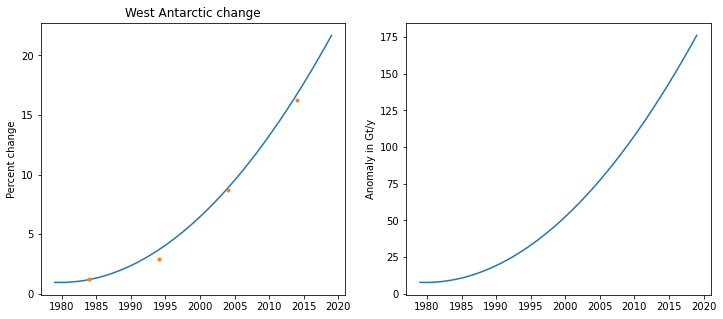

In [31]:
# West Antarctica runoff offset:
# mask this region and add p(time)*total FW input (river + calving)

#p = Polynomial.fit(year,West_Antarctica_percent,deg=2)
p = Polynomial.fit(whole_time[:-2],West_Antarctica_percent_timeseries,deg=2)

time = np.arange(len(runoff1.time))/(365.25)+1979
plt.figure(1,figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(time,p(time)*100)
plt.plot(year,West_Antarctica_percent*100,'.')
plt.ylabel('Percent change')
plt.title('West Antarctic change')

West_Antarctica_offset = runoff1.sel(lat=lat_slice)*0 + runoff*AB_mask
West_Antarctica_offset = West_Antarctica_offset*p(time)[:,np.newaxis,np.newaxis]
West_Antarctica_offset = West_Antarctica_offset.load()
# check this looks right when converted back to Gt/y:
test = (West_Antarctica_offset*area).sum('lon').sum('lat')*conversion_factor
plt.subplot(1,2,2)
plt.plot(time,test)
plt.ylabel('Anomaly in Gt/y');

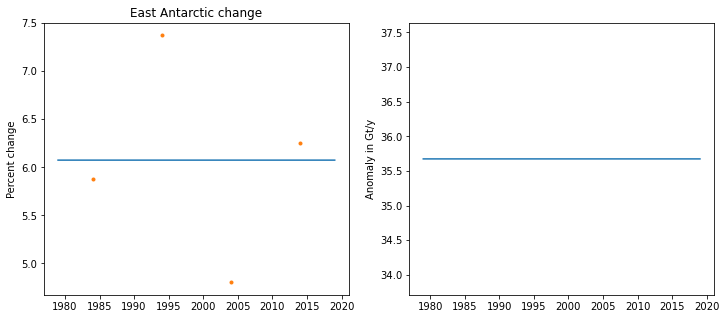

In [33]:
# East Antarctica runoff offset:
# mask this region and add p(time)*total FW input (river + calving)

p = Polynomial.fit(year,East_Antarctica_percent,deg=0)

time = np.arange(len(runoff1.time))/(365.25)+1979
plt.figure(1,figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(time,p(time)*100)
plt.plot(year,East_Antarctica_percent*100,'.')
plt.ylabel('Percent change')
plt.title('East Antarctic change')

East_Antarctica_offset = runoff1.sel(lat=lat_slice)*0 + runoff*Wilkes_mask
East_Antarctica_offset = p(time)[:,np.newaxis,np.newaxis]*East_Antarctica_offset
East_Antarctica_offset = East_Antarctica_offset.load()
# check this looks right when converted back to Gt/y:
test = (East_Antarctica_offset*area).sum('lon').sum('lat')*conversion_factor
plt.subplot(1,2,2)
plt.plot(time,test)
plt.ylabel('Anomaly in Gt/y');

In [34]:
sum_3regions = Peninsula_offset.fillna(0) + West_Antarctica_offset.fillna(0) + East_Antarctica_offset.fillna(0)
#sum_3regions
save_dir = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v140_iaf_cycle3_freshwater/'

ds_sum_3regions = xr.Dataset({'sum_3regions': sum_3regions})
ds_sum_3regions.to_netcdf(save_dir+'sum_3regions_1979_2018.nc',encoding={'sum_3regions':{'zlib':True,'complevel': 5}})

## Save offset file:

In [ ]:
# open saved data:
outpath = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v140_iaf_cycle3_freshwater/sum_3regions_1979_2018.nc'
saved_data = xr.open_dataset(outpath)
sum_3regions = saved_data.sum_3regions

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/asyncio/selector_events.py", line 261, in _add_reader
    key = self._selector.get_key(fd)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/selectors.py", line 193, in get_key
    raise KeyError("{!r} is not registered".format(fileobj)) from None
KeyError: '221 is not registered'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sq

In [5]:
# first zero out runoff in file to save in using nco (I couldn't load it here for some reason).
# see zero_netcdf_script.sh in /g/data/v45/akm157/model_data/access-om_input/01deg_jra55v140_iaf_cycle3_freshwater/
# zeroed file is here: friver_offset_zeroed_1979_2018.nc. Make a copy of that to overwrite below.

distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/worker.py", line 1260, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/utils_comm.py", line 385, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/distributed/utils_comm.py", line 370, in retry
    return await coro()
  File "/g/data/hh5/public/apps/miniconda

KeyboardInterrupt: 

In [35]:
# copy zeroed file to write into:
zero_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v140_iaf_cycle3_freshwater/friver_offset_zeroed_1979_2018.nc'
outpath = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v140_iaf_cycle3_freshwater/friver_offset_19790101-20190105.nc'
shutil.copyfile(zero_file,outpath);

# open in writing mode:
ncFile = nc.Dataset(outpath,'r+')

# then replace Antarctic values with offset values:
ncFile.variables['friver'][:,:len(sum_3regions.lat),:] = sum_3regions.values

ncFile.close()

## Plot bar charts:

In [15]:
# Paolo ice-shelf thinning rates (take as constant over 3 decades):
paolo_AB = np.array((100.3+19.3,100.3+19.3,100.3+19.3,100.3+19.3))
paolo_Ross = np.array((69,69,69,69))
paolo_Peninsula = np.array((25.8+39.6,25.8+39.6,25.8+39.6,25.8+39.6))

rignot_AB = np.array((9.9,23.7,70.6,131.9))
rignot_Peninsula = np.array((7.6,12.1,31.3,45.1))
rignot_Wilkes = np.array((34.5,43.3,28.2,36.7))

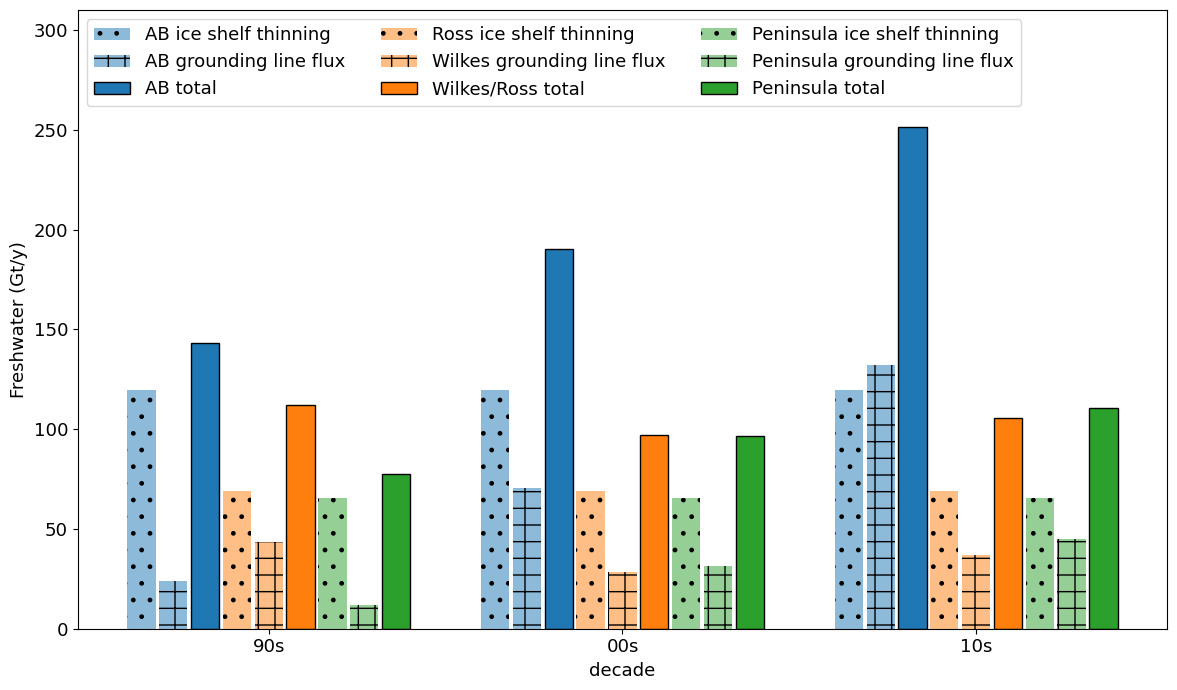

In [19]:
# Absolute mass fluxes:

x = np.arange(3)  # the label locations
width = 0.08  # the width of the bars

fig, ax = plt.subplots(figsize=(12,7))
rects1 = ax.bar(x - 4*width-.04, paolo_AB, width,color='C0',hatch='.',alpha=0.5,label='AB ice shelf thinning')
rects2 = ax.bar(x - 3*width-.03, rignot_AB, width,color='C0',hatch='+',alpha=0.5, label='AB grounding line flux')
rects2 = ax.bar(x - 2*width-.02, rignot_AB+paolo_AB, width,color='C0',edgecolor='k',label='AB total')
rects1 = ax.bar(x - width-.01, paolo_Ross, width,color='C1',hatch='.',alpha=0.5,label='Ross ice shelf thinning')
rects2 = ax.bar(x, rignot_Wilkes, width,color='C1',hatch='+',alpha=0.5, label='Wilkes grounding line flux')
rects2 = ax.bar(x + width+.01, rignot_Wilkes+paolo_Ross, width,color='C1',edgecolor='k',label='Wilkes/Ross total')
rects1 = ax.bar(x + 2*width+.02, paolo_Peninsula, width,color='C2',hatch='.',alpha=0.5,label='Peninsula ice shelf thinning')
rects2 = ax.bar(x + 3*width+.03, rignot_Peninsula, width,color='C2',hatch='+', alpha=0.5,label='Peninsula grounding line flux')
rects2 = ax.bar(x + 4*width+.04, rignot_Peninsula+paolo_Peninsula, width,color='C2', edgecolor='k',label='Peninsula total')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Freshwater (Gt/y)',fontsize=fontsize)
ax.set_xlabel('decade',fontsize=fontsize)
#ax.set_title('Heat transport components',fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels(['90s','00s','10s'])
ax.legend(fontsize=fontsize,loc=2,ncol=3)
plt.tick_params(labelsize=fontsize)
#plt.plot([-1,4],[0,0],'k')
#plt.xlim(-.5,3.5)
plt.ylim(0,310)
fig.tight_layout()

figure_path = figdir+'mass_anomalies_barchart.pdf'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)

In [22]:
paolo_AB/AB_runoff.values*100

array([13.56083429, 13.56083429, 13.56083429, 13.56083429])

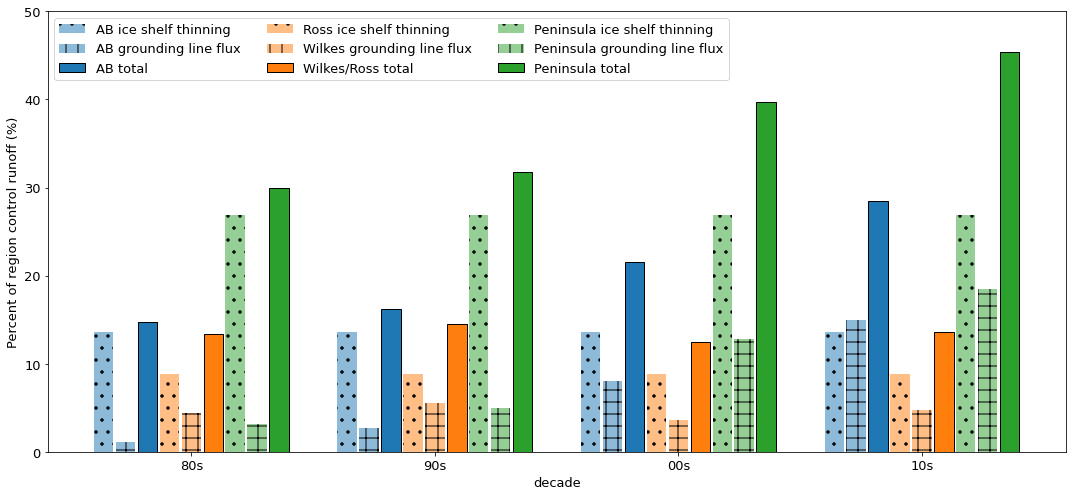

In [25]:
# As percentages of control:

# Absolute mass fluxes:

x = np.arange(4)  # the label locations
width = 0.08  # the width of the bars

fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - 4*width-.04, paolo_AB/AB_runoff.values*100, width,color='C0',hatch='.',alpha=0.5,label='AB ice shelf thinning')
rects2 = ax.bar(x - 3*width-.03, rignot_AB/AB_runoff.values*100, width,color='C0',hatch='+',alpha=0.5, label='AB grounding line flux')
rects2 = ax.bar(x - 2*width-.02, (rignot_AB+paolo_AB)/AB_runoff.values*100, width,color='C0',edgecolor='k',label='AB total')
rects1 = ax.bar(x - width-.01, paolo_Ross/Wilkes_Ross_runoff.values*100, width,color='C1',hatch='.',alpha=0.5,label='Ross ice shelf thinning')
rects2 = ax.bar(x, rignot_Wilkes/Wilkes_Ross_runoff.values*100, width,color='C1',hatch='+',alpha=0.5, label='Wilkes grounding line flux')
rects2 = ax.bar(x + width+.01, (rignot_Wilkes+paolo_Ross)/Wilkes_Ross_runoff.values*100, width,color='C1',edgecolor='k',label='Wilkes/Ross total')
rects1 = ax.bar(x + 2*width+.02, paolo_Peninsula/Peninsula_runoff.values*100, width,color='C2',hatch='.',alpha=0.5,label='Peninsula ice shelf thinning')
rects2 = ax.bar(x + 3*width+.03, rignot_Peninsula/Peninsula_runoff.values*100, width,color='C2',hatch='+', alpha=0.5,label='Peninsula grounding line flux')
rects2 = ax.bar(x + 4*width+.04, (rignot_Peninsula+paolo_Peninsula)/Peninsula_runoff.values*100, width,color='C2', edgecolor='k',label='Peninsula total')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of region control runoff (%)',fontsize=fontsize)
ax.set_xlabel('decade',fontsize=fontsize)
#ax.set_title('Heat transport components',fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels(['80s','90s','00s','10s'])
ax.legend(fontsize=fontsize,loc=2,ncol=3)
plt.tick_params(labelsize=fontsize)
#plt.plot([-1,4],[0,0],'k')
#plt.xlim(-.5,3.5)
plt.ylim(0,50)
fig.tight_layout()

figure_path = figdir+'percent_anomalies_barchart.pdf'
#fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)


## Experiment with extending meltwater back in time:

In [11]:
# only include Rignot (not Paolo):
Peninsula_percent = rignot_Peninsula/Peninsula_runoff.values*100
West_Antarctica_percent = rignot_West_Antarctica/AB_runoff.values*100
East_Antarctica_percent = rignot_East_Antarctica/Wilkes_Ross_runoff.values*100

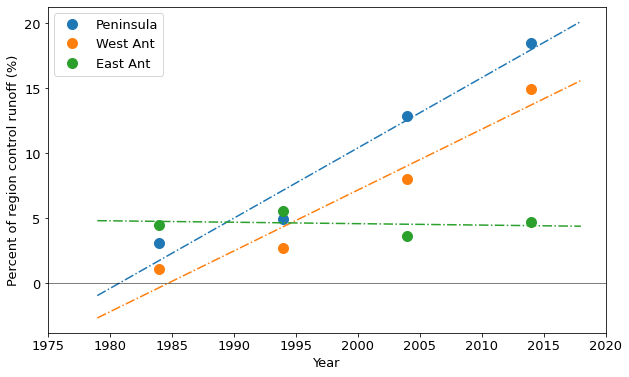

In [12]:
time = np.array([1984,1994,2004,2014])
whole_time = np.arange(1979,2019)
whole_time = xr.DataArray(whole_time, coords = [('year', whole_time)])

#########################
# peninsula fit:
da = xr.DataArray(Peninsula_percent, coords = [('year', time)])
p = da.polyfit(dim='year', deg=1)
peninsula_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)

# West_Antarctica fit:
da = xr.DataArray(West_Antarctica_percent, coords = [('year', time)])
p = da.polyfit(dim='year', deg=1)
West_Antarctica_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)

# East_Antarctica fit:
da = xr.DataArray(East_Antarctica_percent, coords = [('year', time)])
p = da.polyfit(dim='year', deg=1)
East_Antarctica_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)

#########################
# fits that start at zero at 1979:
x = time - 1979
x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, Peninsula_percent)
peninsula_fit_zero = a*(whole_time-1979)

a, _, _, _ = np.linalg.lstsq(x, np.log(West_Antarctica_percent))
West_Antarctica_fit_zero = np.exp(a*(whole_time-1979))

a, _, _, _ = np.linalg.lstsq(x, West_Antarctica_percent)
West_Antarctica_fit_zero_linear = a*(whole_time-1979)

a, _, _, _ = np.linalg.lstsq(x, East_Antarctica_percent)
East_Antarctica_fit_zero = a*(whole_time-1979)

#########################
plt.figure(figsize=(10,6))

plt.plot(time,Peninsula_percent,'o',markersize=10,label='Peninsula')
plt.plot(time,West_Antarctica_percent,'o',markersize=10,linestyle='None',color='C1',label='West Ant')
plt.plot(time,East_Antarctica_percent,'o',markersize=10,linestyle='None',color='C2',label='East Ant')

peninsula_fit.plot(color='C0',linestyle='-.')
West_Antarctica_fit.plot(color='C1',linestyle='-.')
East_Antarctica_fit.plot(color='C2',linestyle='-.')

#plt.plot(whole_time, peninsula_fit_zero,color='C0',linestyle='--')
#plt.plot(whole_time, West_Antarctica_fit_zero,color='C1',linestyle='-')
#plt.plot(whole_time, West_Antarctica_fit_zero_linear,color='C1',linestyle='--')
#plt.plot(whole_time, East_Antarctica_fit_zero,color='C2',linestyle='--')

plt.legend(fontsize=fontsize)

plt.plot([1950,2022],[0,0],'k',linewidth=0.5)
plt.xlim(1975,2020)

plt.ylabel('Percent of region control runoff (%)',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)


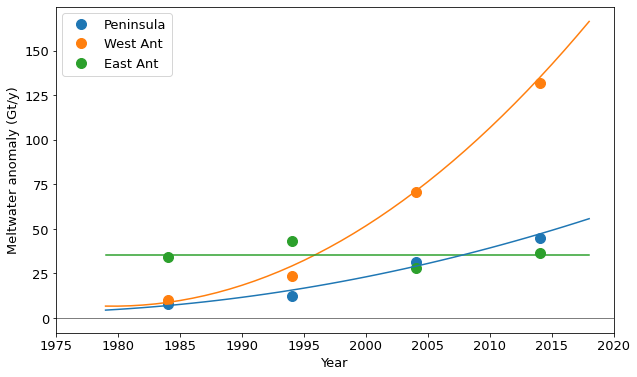

In [18]:
time = np.array([1984,1994,2004,2014])
whole_time = np.arange(1979.,2019.)
whole_time = xr.DataArray(whole_time, coords = [('year', whole_time)])

# first construct time series that have rignot values at annual frequency (not just central point in decades):
west_Ant_timeseries = whole_time.copy()
west_Ant_timeseries[:10] = rignot_West_Antarctica[0]
west_Ant_timeseries[10:20] = rignot_West_Antarctica[1]
west_Ant_timeseries[20:30] = rignot_West_Antarctica[2]
west_Ant_timeseries[30:40] = rignot_West_Antarctica[3]
# rignot finishes a 2017, so cut off last 2 years:
west_Ant_timeseries = west_Ant_timeseries[:-2]

east_Ant_timeseries = whole_time.copy()
east_Ant_timeseries[:10] = rignot_East_Antarctica[0]
east_Ant_timeseries[10:20] = rignot_East_Antarctica[1]
east_Ant_timeseries[20:30] = rignot_East_Antarctica[2]
east_Ant_timeseries[30:40] = rignot_East_Antarctica[3]
east_Ant_timeseries = east_Ant_timeseries[:-2]

peninsula_timeseries = whole_time.copy()
peninsula_timeseries[:10] = rignot_Peninsula[0]
peninsula_timeseries[10:20] = rignot_Peninsula[1]
peninsula_timeseries[20:30] = rignot_Peninsula[2]
peninsula_timeseries[30:40] = rignot_Peninsula[3]
peninsula_timeseries = peninsula_timeseries[:-2]

#########################
# peninsula fit:
da = xr.DataArray(rignot_Peninsula, coords = [('year', time)])
p = da.polyfit(dim='year', deg=2)
peninsula_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)
# fit to annual data:
da = peninsula_timeseries
p = da.polyfit(dim='year', deg=2)
peninsula_annual_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)

# West_Antarctica fit:
da = xr.DataArray(rignot_West_Antarctica, coords = [('year', time)])
p = da.polyfit(dim='year', deg=2)
West_Antarctica_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)
# West_Antarctica fit to annual data:
da = west_Ant_timeseries
p = da.polyfit(dim='year', deg=2)
West_Antarctica_annual_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)

# East_Antarctica fit:
da = xr.DataArray(rignot_East_Antarctica, coords = [('year', time)])
p = da.polyfit(dim='year', deg=0)
East_Antarctica_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)
# fit to annual data:
da = east_Ant_timeseries
p = da.polyfit(dim='year', deg=0)
East_Antarctica_annual_fit = xr.polyval(whole_time.year, p.polyfit_coefficients)

#########################
plt.figure(figsize=(10,6))

plt.plot(time,rignot_Peninsula,'o',markersize=10,label='Peninsula')
plt.plot(time,rignot_West_Antarctica,'o',markersize=10,linestyle='None',color='C1',label='West Ant')
plt.plot(time,rignot_East_Antarctica,'o',markersize=10,linestyle='None',color='C2',label='East Ant')

# fits to annual data:
West_Antarctica_annual_fit.plot(color='C1',linestyle='-')
East_Antarctica_annual_fit.plot(color='C2',linestyle='-')
peninsula_annual_fit.plot(color='C0',linestyle='-')

plt.legend(fontsize=fontsize)

plt.plot([1950,2022],[0,0],'k',linewidth=0.5)
plt.xlim(1975,2020)

plt.ylabel('Meltwater anomaly (Gt/y)',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)


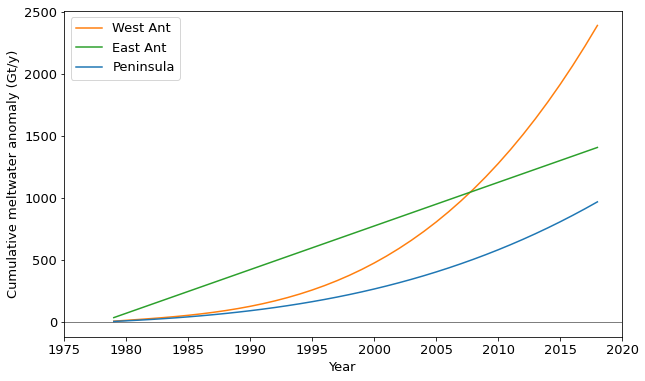

In [22]:
# plot cumulative meltwater anomaly:

#########################
plt.figure(figsize=(10,6))

# fits to annual data:
West_Antarctica_annual_fit.cumsum('year').plot(color='C1',linestyle='-',label='West Ant')
East_Antarctica_annual_fit.cumsum('year').plot(color='C2',linestyle='-',label='East Ant')
peninsula_annual_fit.cumsum('year').plot(color='C0',linestyle='-',label='Peninsula')

plt.legend(fontsize=fontsize)

plt.plot([1950,2022],[0,0],'k',linewidth=0.5)
plt.xlim(1975,2020)

plt.ylabel('Cumulative meltwater anomaly (Gt/y)',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
